In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

import dateutil.relativedelta
import seaborn as sns

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [16]:
raw_df = pd.read_csv('rosbank_train.csv')

Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [17]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [18]:
raw_df['DATE_'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')))

In [19]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  392467
Total transactions in test dataset:  98046


## Предобработка

In [6]:
# raw_df_grouped = raw_df[
#     ['cl_id', 'amount', 'MCC']
# ].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

# # aggregated_dataset = raw_df_grouped.unstack().fillna(0)
# aggregated_dataset = raw_df_grouped.unstack()

In [20]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

# transaction_by_day_count(raw_df)

In [21]:
testdf = transactions_train[transactions_train['cl_id']==5].groupby(['cl_id']).fillna(0).reset_index()

In [22]:
transactions_train[transactions_train['cl_id']==5].groupby(['cl_id','DATE_','MCC','trx_category']).agg(['count'])

PERIOD channel_type currency  \
                                               count        count    count   
cl_id DATE_               MCC  trx_category                                  
5     2017-03-18 00:00:00 5651 POS                 1            0        1   
                          5813 POS                 1            0        1   
      2017-03-19 00:00:00 5651 BACK_TRX            1            0        1   
                          5691 POS                 1            0        1   
      2017-03-20 00:00:00 4722 POS                 1            0        1   
                          5411 POS                 1            0        1   
      2017-03-21 00:00:00 5411 POS                 1            0        1   
                          7922 POS                 1            0        1   
      2017-03-24 00:00:00 5691 POS                 1            0        1   
                          5812 POS                 1            0        1   
                          5977 POS                 1            0        1   
      2017-03-25 00:00:00 6011 WD_ATM_PARTNER      1            0        1   
      2017-03-27 00:00:00 4814 POS                 1            0        1   
      2017-03-29 00:00:00 4131 POS                 1            0        1   
      2017-03-29 13:56:00 6011 WD_ATM_ROS          1            0        1   
      2017-03-31 00:00:00 5411 POS                 1            0        1   
                          9222 POS                 1            0        1   
      2017-04-01 00:00:00 5411 POS                 1            0        1   
      2017-04-02 00:00:00 5411 POS                 1            0        1   
                          8011 POS                 1            0        1   
      2017-04-05 00:00:00 5977 POS                 1            0        1   
      2017-04-06 00:00:00 5411 POS                 1            0        1   
                          5621 POS                 1            0        1   
                          5735 POS                 1            0        1   
                          7991 POS                 1            0        1   
      2017-04-06 17:02:19 6011 DEPOSIT             1            0        1   
      2017-04-06 17:03:05 6011 DEPOSIT             1            0        1   
      2017-04-07 00:00:00 5812 POS                 1            0        1   
      2017-04-08 00:00:00 5691 POS                 1            0        1   
                          5977 POS                 1            0        1   
...                                              ...          ...      ...   
      2017-05-27 00:00:00 5411 POS                 1            0        1   
      2017-05-28 00:00:00 7011 POS                 1            0        1   
      2017-05-29 00:00:00 5411 POS                 1            0        1   
                          6011 WD_ATM_PARTNER      1            0        1   
      2017-06-01 00:00:00 4814 POS                 1            0        1   
      2017-06-02 00:00:00 5411 POS                 1            0        1   
                          5735 POS                 1            0        1   
      2017-06-03 00:00:00 5499 POS                 2            0        2   
                          6011 WD_ATM_OTHER        2            0        2   
      2017-06-05 00:00:00 5995 POS                 2            0        2   
      2017-06-05 11:49:36 6011 WD_ATM_ROS          1            0        1   
      2017-06-06 00:00:00 7922 POS                 1            0        1   
      2017-06-06 19:34:15 6011 DEPOSIT             1            0        1   
      2017-06-06 19:34:58 6011 DEPOSIT             1            0        1   
      2017-06-08 00:00:00 5331 POS                 1            0        1   
                          5691 POS                 1            0        1   
                          5941 POS                 1            0        1   
      2017-06-09 00:00:00 5411 POS                 1            0   

In [23]:
print(min(testdf['DATE_']))
print(max(testdf['DATE_']))
print(testdf['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=12)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=6)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=3)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=2)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=1)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1)]['DATE_'].count())

2017-03-18 00:00:00
2017-06-18 00:00:00
142
142
142
140
100
44
30
18


In [24]:
set(list(raw_df.trx_category))

{'BACK_TRX',
 'C2C_IN',
 'C2C_OUT',
 'CASH_ADV',
 'CAT',
 'DEPOSIT',
 'POS',
 'WD_ATM_OTHER',
 'WD_ATM_PARTNER',
 'WD_ATM_ROS'}

In [30]:
type_for_gen = ['C2C_OUT','WD_ATM_ROS','DEPOSIT','WD_ATM_OTHER','WD_ATM_PARTNER']

In [31]:
def date_diff_df(cl_id_df):
    index=range(0,1)
    columns=['last12m','last6m','last2m','last1m','last2w','last1w']
    ret_df = pd.DataFrame(index=index, columns=columns)
    counter = cl_id_df.shape[0]
    ret_df['last12m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12)]['DATE_'].count()/365
    ret_df['last6m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6)]['DATE_'].count()/183
    ret_df['last2m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2)]['DATE_'].count()/61
    ret_df['last1m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1)]['DATE_'].count()/30
    ret_df['last2w'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2)]['DATE_'].count()/14
    ret_df['last1w'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1)]['DATE_'].count()/7

    for op_type in set(type_for_gen):
#         counter_2 = cl_id_df[op_type].shape[0]
        ret_df['last12m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12))]['DATE_'].count()/365
        ret_df['last6m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6))]['DATE_'].count()/183
        ret_df['last2m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2))]['DATE_'].count()/61
        ret_df['last1m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1))]['DATE_'].count()/30
        ret_df['last2w'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2))]['DATE_'].count()/14
        ret_df['last1w'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1))]['DATE_'].count()/7
        
    return ret_df

In [32]:
date_diff_df(testdf)

,last12m,last6m,last2m,last1m,last2w,last1w,last12mWD_ATM_OTHER,last6mWD_ATM_OTHER,last2mWD_ATM_OTHER,last1mWD_ATM_OTHER,...,last2mC2C_OUT,last1mC2C_OUT,last2wC2C_OUT,last1wC2C_OUT,last12mWD_ATM_ROS,last6mWD_ATM_ROS,last2mWD_ATM_ROS,last1mWD_ATM_ROS,last2wWD_ATM_ROS,last1wWD_ATM_ROS
0,0.389041,0.775956,1.639344,1.466667,2.142857,2.571429,0.005479,0.010929,0.032787,0.066667,...,0.098361,0.066667,0.142857,0.285714,0.038356,0.076503,0.196721,0.033333,0.071429,0.0


In [33]:
train_cl_stat = raw_df.groupby(['cl_id']).apply(date_diff_df)
train_cl_stat = train_cl_stat.reset_index().drop(['level_1'],axis=1).set_index('cl_id')

In [34]:
transaction_by_day = transaction_by_day_count(raw_df)
transaction_by_day = transaction_by_day.set_index('cl_id')

transaction_by_hour = transaction_by_hour_count(raw_df)
transaction_by_hour = transaction_by_hour.set_index('cl_id')

### Агрегирование с помощью Pandas и обучение базовой модели

In [35]:
def max_date(df):
    agg_df = df.groupby('cl_id')['PERIOD'].max()
    return agg_df

In [36]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [37]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [38]:
def max_date_of_transaction(df):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [41]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [42]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_train_1 = pd.merge(
    df_train_mcc,
    df_train_trx_category,
    left_index=True,
    right_index=True,
)

df_time_train = pd.merge(
    transaction_by_day,
    transaction_by_hour,
    left_index=True,
    right_index=True,)

df_train = pd.merge(
    df_time_train,
    df_train_1,
    left_index=True,
    right_index=True,)

df_train = pd.merge(
    train_cl_stat,
    df_train,
    left_index=True,
    right_index=True,)

# df_train = pd.merge(
#     pd.DataFrame(max_date(transactions_train)),
#     df_train,
#     left_index=True,
#     right_index=True,)

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder().fit(df_train['PERIOD'])
# df_train['PERIOD'] = le.transform(df_train['PERIOD'])
# df_train = get_one_hot(df_train, ['PERIOD'])
# df_train = df_train.drop(['PERIOD'], axis = 1)


df_train = pd.merge(
    df_train,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

### test data

In [43]:
df_test_mcc = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_test_trx_category = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_test_1 = pd.merge(
    df_test_mcc,
    df_test_trx_category,
    left_index=True,
    right_index=True,
)

df_time_test = pd.merge(
    transaction_by_day,
    transaction_by_hour,
    left_index=True,
    right_index=True,)
    
df_test = pd.merge(
    df_time_test,
    df_test_1,
    left_index=True,
    right_index=True,)

df_test = pd.merge(
    train_cl_stat,
    df_test,
    left_index=True,
    right_index=True,)

# df_test = pd.merge(
#     pd.DataFrame(max_date(transactions_test)),
#     df_test,
#     left_index=True,
#     right_index=True,)

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder().fit(df_test['PERIOD'])
# df_test['PERIOD'] = le.transform(df_test['PERIOD'])
# df_test = get_one_hot(df_test, ['PERIOD'])
# df_test = df_test.drop(['PERIOD'], axis = 1)


df_test = pd.merge(
    df_test,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [44]:
list(df_test.columns)

['last12m',
 'last6m',
 'last2m',
 'last1m',
 'last2w',
 'last1w',
 'last12mWD_ATM_OTHER',
 'last6mWD_ATM_OTHER',
 'last2mWD_ATM_OTHER',
 'last1mWD_ATM_OTHER',
 'last2wWD_ATM_OTHER',
 'last1wWD_ATM_OTHER',
 'last12mWD_ATM_PARTNER',
 'last6mWD_ATM_PARTNER',
 'last2mWD_ATM_PARTNER',
 'last1mWD_ATM_PARTNER',
 'last2wWD_ATM_PARTNER',
 'last1wWD_ATM_PARTNER',
 'last12mDEPOSIT',
 'last6mDEPOSIT',
 'last2mDEPOSIT',
 'last1mDEPOSIT',
 'last2wDEPOSIT',
 'last1wDEPOSIT',
 'last12mC2C_OUT',
 'last6mC2C_OUT',
 'last2mC2C_OUT',
 'last1mC2C_OUT',
 'last2wC2C_OUT',
 'last1wC2C_OUT',
 'last12mWD_ATM_ROS',
 'last6mWD_ATM_ROS',
 'last2mWD_ATM_ROS',
 'last1mWD_ATM_ROS',
 'last2wWD_ATM_ROS',
 'last1wWD_ATM_ROS',
 'day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 'MCC_mean_742',
 'MCC_mean_763',
 'MCC_mean_1520',
 'MCC_me

In [45]:
df_test.shape

(1000, 612)

### train test split

In [46]:
X_test = df_test.drop(['target_flag'], axis=1)
y_test = df_test['target_flag']

In [47]:
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

### random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [49]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [50]:
len(cols)

583

In [66]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [67]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [68]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.81


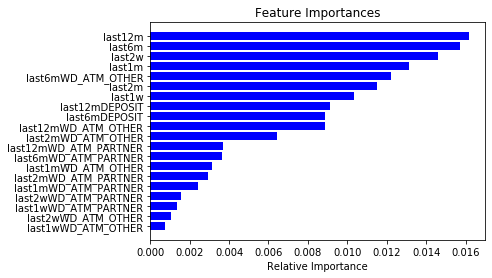

In [70]:
features = X_train.columns
importances = clf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [58]:
importances_p = clf.feature_importances_[0:20]
indices_p = np.argsort(importances_p)

In [59]:
[features[i] for i in indices_p]+['target_flag']

['last1wWD_ATM_OTHER',
 'last2wWD_ATM_PARTNER',
 'last1wWD_ATM_PARTNER',
 'last2wWD_ATM_OTHER',
 'last1mWD_ATM_PARTNER',
 'last2mWD_ATM_PARTNER',
 'last12mWD_ATM_PARTNER',
 'last1mWD_ATM_OTHER',
 'last6mWD_ATM_PARTNER',
 'last2mWD_ATM_OTHER',
 'last12mDEPOSIT',
 'last12mWD_ATM_OTHER',
 'last6mDEPOSIT',
 'last2m',
 'last1w',
 'last1m',
 'last6mWD_ATM_OTHER',
 'last2w',
 'last6m',
 'last12m',
 'target_flag']

/Users/k.gusev/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/k.gusev/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/k.gusev/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


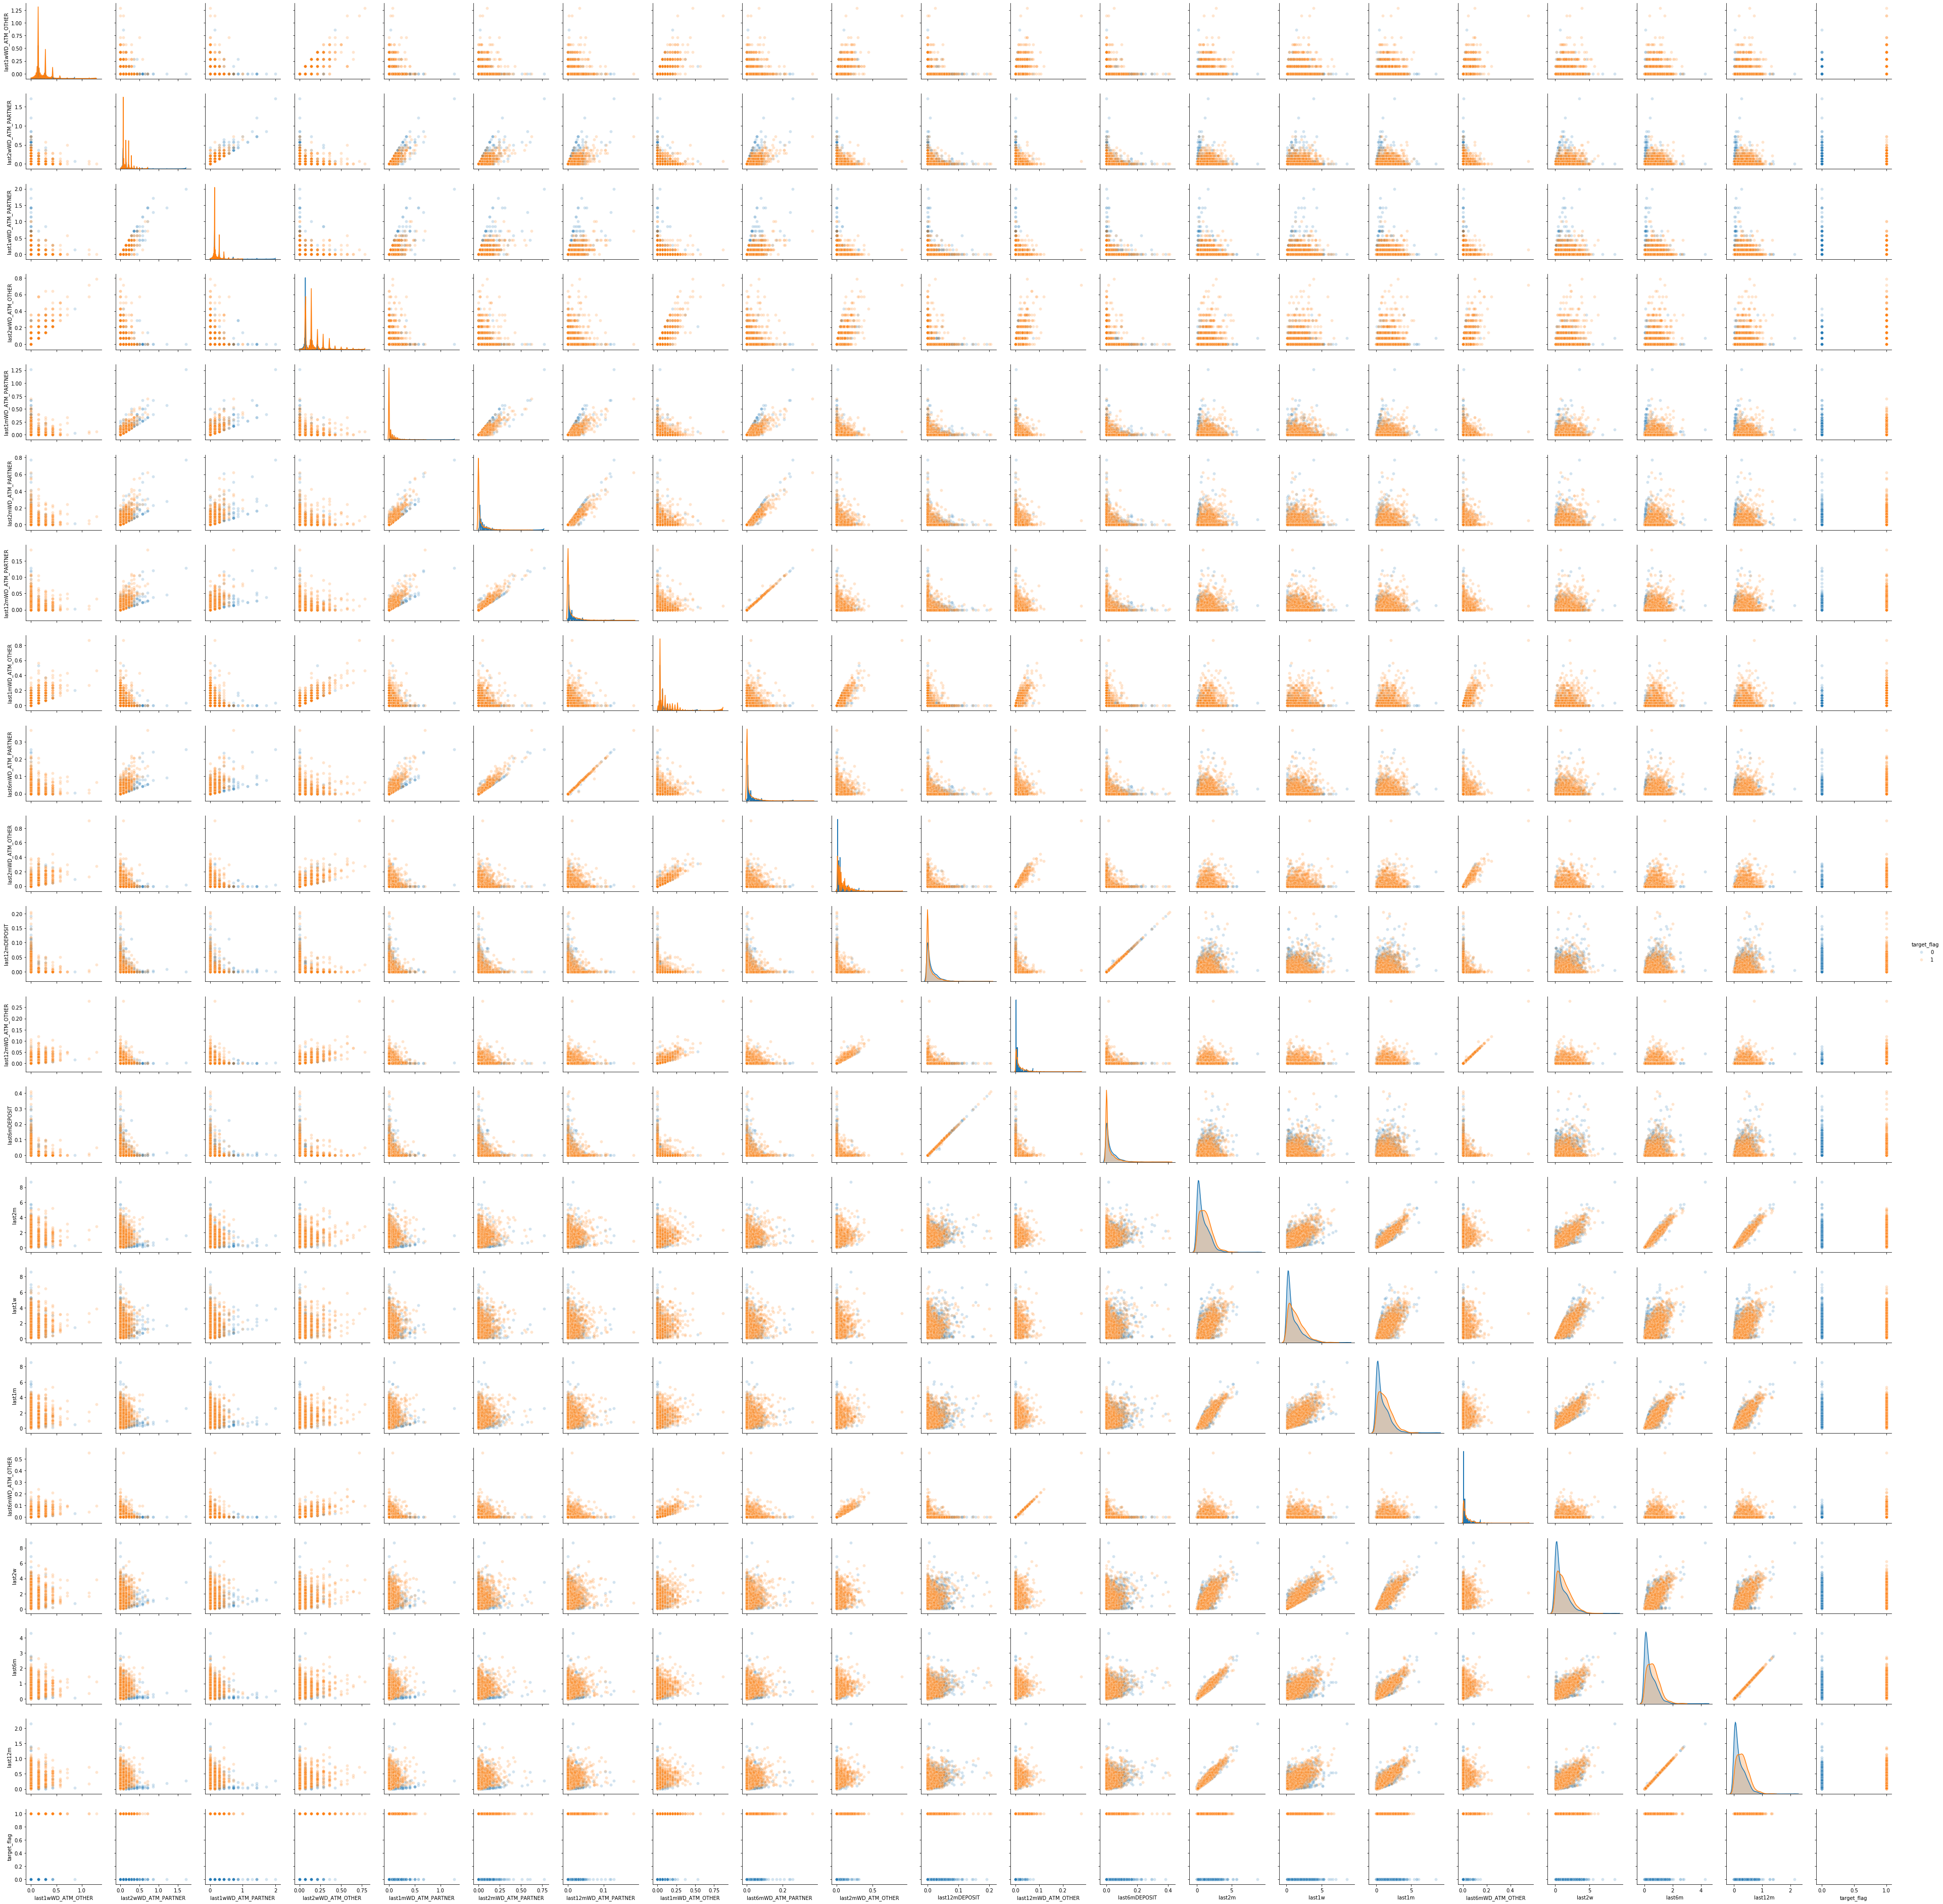

In [60]:
sns.pairplot(data=df_train[[features[i] for i in indices_p]+['target_flag']],plot_kws={'alpha':0.2},hue='target_flag');